# Figure 5

In [1]:
### Loads relevant python libraries ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import scipy.fftpack as fft
import scipy.ndimage as ndi
import scipy as sp
import os
import glob
import re
from PIL import Image
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
import matplotlib.image as mpimg
import csv

# Alters font size
plt.rcParams.update({'font.size':12})

In [2]:
### Defines relevant fitting functions ###
# Standard sine function
def sine(values, A, w, p, bg):
    return A*np.sin(values*w+p)+bg

# Cubic background function
def cubic(values,a,l,k,m,c):
    return a*values**4+l*values**3+k*values**2+m*values+c

# Sine function and cubic background function
def both(values, a, l, k, m, c, A, w, p):
    return a*values**4+l*values**3+k*values**2+m*values+c+A*np.sin(values*w+p)

# Linear background function
def line(values, m, c):
    return values*m + c

# Loading Conical Line Scans

This section of code analyses data of a field sweep performed after cooling at 0 mT form above Tc to 100 K, showing the helical state transition to the conical state. 
All linescan data was extracted by averaging the counts along cuts through the relevant magnetic region in each raw STXM image using the widely-available imageJ program.

In [3]:
#Load cone line scans
fields = [20,40,60,80,100,120,140,160,180,200]

# Sets up lists for storing intensity, pixel number, and error.
lists = []
pxs = []
errs = []

for i in np.arange(0,len(fields),1):
    with open('STXM_Lineprofiles/Cone_'+str(fields[i])+'mT.csv', 'r') as f:
        cone = list(csv.reader(f, delimiter=';'))
    cone = np.array(cone[1:], dtype=np.float)
    cone = np.rot90(cone)
    lists.append(cone[0][4:45])
    cone_pxs = np.arange(0,len(cone[0][4:45]),1)
    err = np.sqrt(cone[0][4:45])
    pxs.append(cone_pxs)
    errs.append(err)

# Fits the Conical Linescan Data

In [4]:
## Gets good starting paramater values for a cubic background #

# Sets up lists for storing fitting parameters, error array, fitted profiles
pms1 = []
arrays1 = []
fits1 = []
lfits1 = []
lpxs = []

# Fits the linescan data to a cubic function, estimating the cubic background.
for i in np.arange(0,len(lists),1):
    pm, array = curve_fit(cubic, pxs[i], lists[i], p0=(1,1,1,1,9000), sigma = errs[i], absolute_sigma=True, maxfev=10000)
    fit = cubic(pxs[i],*pm)
    lpx = np.linspace(0,len(pxs[i])-1,1000)
    lpxs.append(lpx)
    lfit = cubic(lpx,*pm)
    pms1.append(pm)
    arrays1.append(array)
    fits1.append(fit)
    lfits1.append(lfit)

In [5]:
## Gets good parameters for the sine function by subtracting the previous cubic background ##

# Sets up lists for storing fitting parameters, error array, fitted profiles
pms2 = []
arrays2 = []
fits2 = []
lens1 = []
As1 = []

# Starting parameter values for each linescan
p0s = ([-3.65033883e+02,  1.39747414e+00, -1.07108413e-01, 0],
[2.52858768e+02,  1.39729114e+00, -8.64319828e-01, 0],
[-2.35584719e+02,  1.41794476e+00, -5.80492958e+00, 0],
[-3.69539740e+02,  1.39204648e+00, -2.34702428e+00, 0],
[-3.77691407e+02,  1.41227605e+00, -1.18473775e+00, 0],
[-3.54619884e+02,  1.40202577e+00, -2.21506448e+00, 0],
[-3.05514093e+02,  1.38886519e+00, -2.64779689e+00, 0],
[1.72251938e+02,  1.32824638e+00, -5.20270560e-02, 0],
[-2.19063511e+02,  1.42531031e+00, -1.66501558e+00, 0],
[1.41071463e+02,  1.32859173e+00, -2.50263643e-01, 0])

# Subtracts the cubic background from the linescan data, and fits to a sine function.
for i in np.arange(0,len(lists),1):
    pm, array = curve_fit(sine, pxs[i], lists[i]-fits1[i], p0=p0s[i], absolute_sigma=True, maxfev=10000)
    fit = sine(pxs[i],*pm)
    pms2.append(pm)
    arrays2.append(array)
    fits2.append(fit)
    lens1.append(pm[1])
    As1.append(abs(pm[0]))

In [6]:
## Performs a full fit of the data with both cubic background and sinewave contribution. ##

# Sets up lists for storing fitting parameters, error array, fitted profiles
pms3 = []
arrays3 = []
fits3 = []
lfits3 = []
lens2 = []
elist = []
elist2 = []

# Sets up lists for storing amplitudes (As) and Wavelengths (lams) of the conical linescans.
As2 = []
lams2 = []

# Starting parameter values for each linescan
p0s = ([ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00],
      [ 1.08e-02, -1.54e+00,  8.20e+01, -8.47e+02, 9.40e+04, -3.92e+02,  1.41e+00, -1.26e+00])


#Fits each conical linescan to the sine + cubic background function. 
for i in np.arange(0,len(lists),1):
    pm, array = curve_fit(both, pxs[i], lists[i], p0=p0s[i], sigma = errs[i], absolute_sigma=True, maxfev=10000)
    fit = both(pxs[i],*pm)
    lfit = both(lpxs[i],*pm)

#Stores relevant prameters and fitting lists.
    pms3.append(pm)
    arrays3.append(array)
    fits3.append(fit)
    lfits3.append(lfit)
    lens2.append(30*np.pi/pm[6])
    As2.append(abs(pm[5]))
    lams2.append(30*np.pi/pm[6])
  
    elist.append(np.sqrt(np.diag(array))[5])
    elist2.append(30*np.sqrt(np.diag(array))[6])

# Plotting Fitted Conical Linescans

<IPython.core.display.Javascript object>


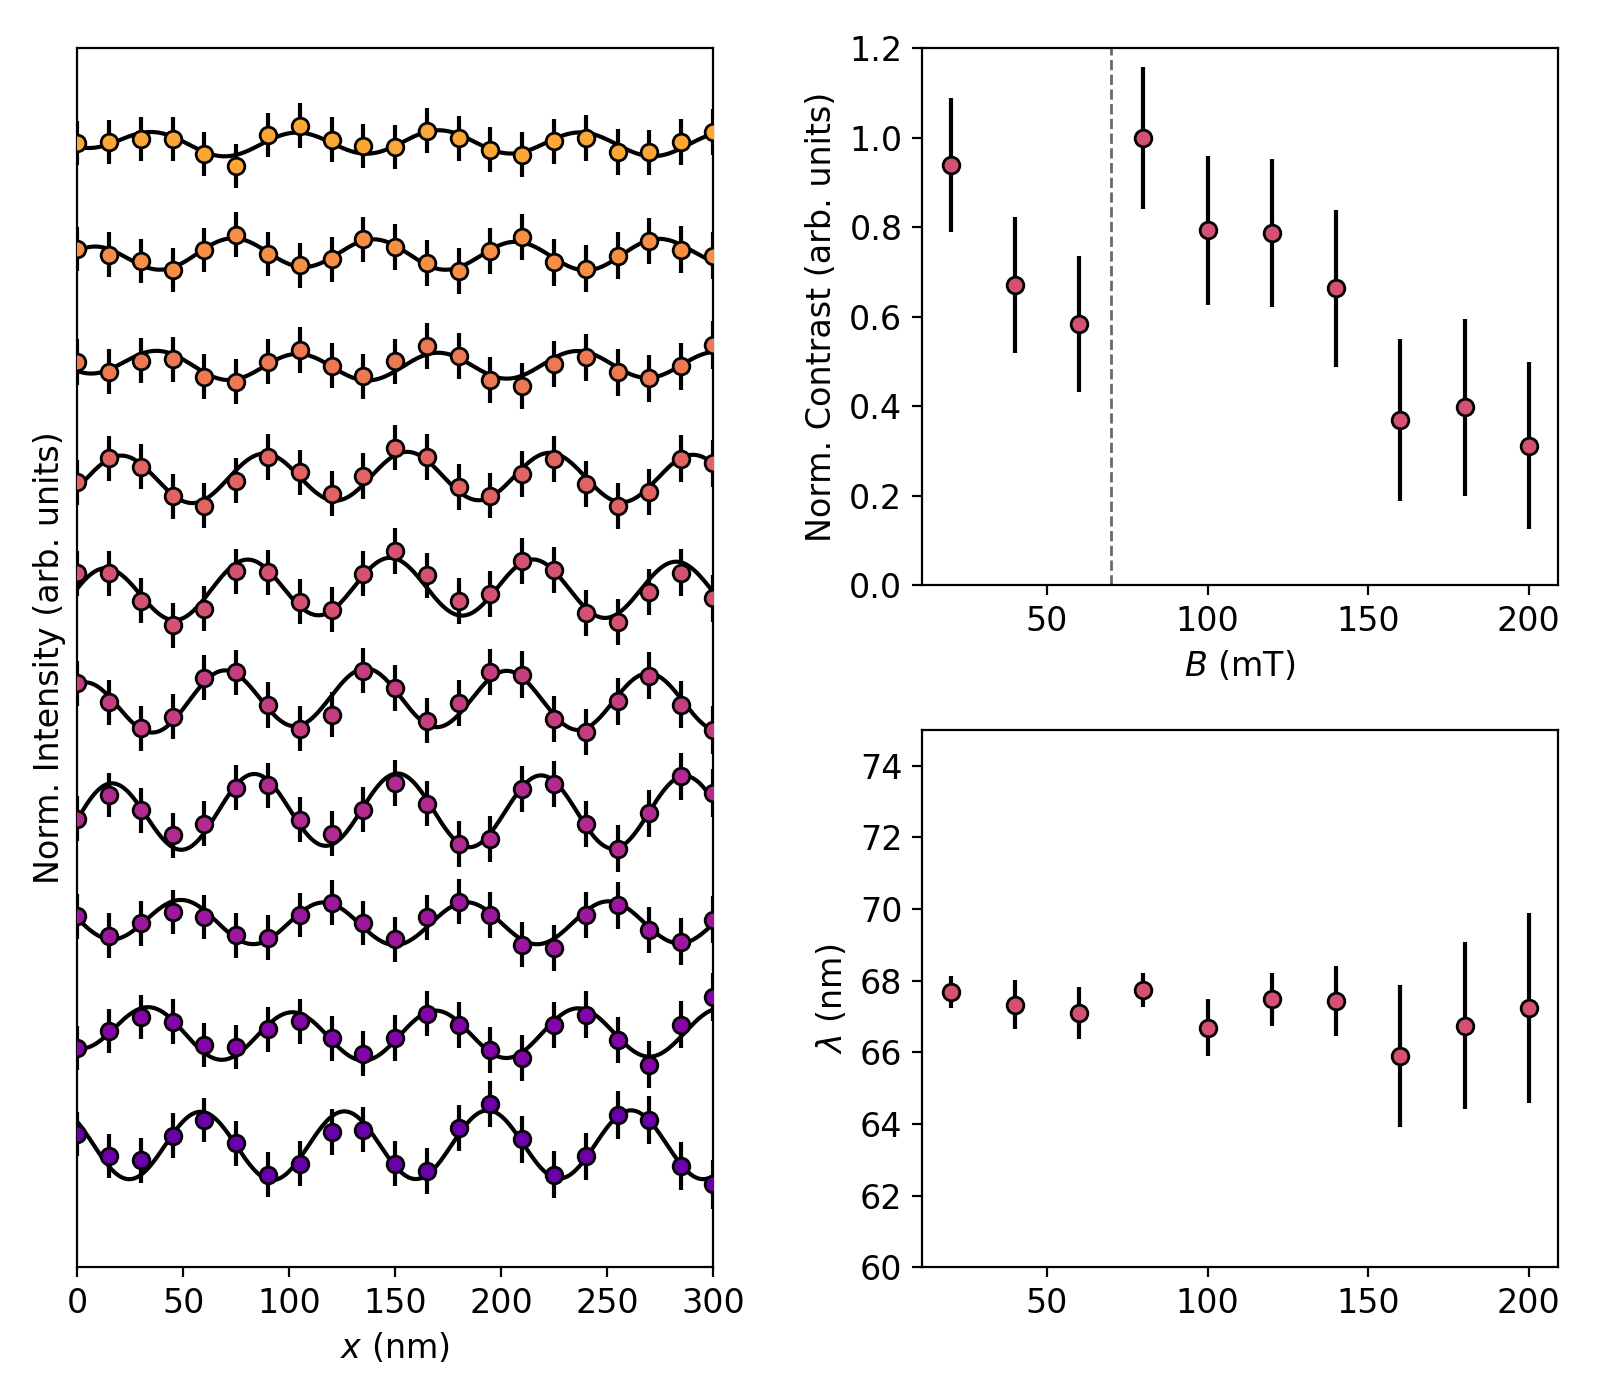

In [7]:
%matplotlib notebook
plt.figure(figsize=(8,7))

# Sets up nice colours for plot
start = 0.2
stop = 0.8
number_of_lines = len(lists)
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.plasma(x) for x in cm_subsection ]


### Plots raw and fitted linescans and associated error bars ###
ax1=plt.subplot2grid((2,2),(0,0), rowspan=2,colspan=1)
for i in np.arange(0,len(lists),1):
    plt.plot(lpxs[i]*15,lfits3[i]/1000+i*1.5-lfits1[i]/1000,color='k',zorder=1)
    plt.errorbar(pxs[i]*15,lists[i]/1000+i*1.5-fits1[i]/1000, yerr = errs[i]/1000,color='k',zorder=2,ls='')
    plt.plot(pxs[i]*15,lists[i]/1000+i*1.5-fits1[i]/1000,color=colors[i],marker='o',markeredgecolor='k',zorder=3,ls='')
plt.xlim((0,300))
plt.yticks([])
plt.ylabel('Norm. Intensity (arb. units)')
plt.xlabel('$x$ (nm)')


### Plots fitted normalised contrast of each linescan and associated errors bars as function of ###
### applied in-plane field ###
ax2=plt.subplot2grid((2,2),(0,1), rowspan=1,colspan=1)
plt.errorbar(fields,As2/max(As2), yerr = elist/max(As2),color='k',ls='',zorder=2)
plt.plot(fields,As2/max(As2),marker='o',color=colors[5],markeredgecolor='k',ls='',zorder=3)

plt.plot((70,70),(0,1.2),color='dimgrey',ls='--',lw=1)
plt.ylim((0,1.2))
plt.ylabel('Norm. Contrast (arb. units)')
plt.xlabel('$B$ (mT)')


### Plots fitted conical wavelength of each linescan as a function of applied in-plane field ###
ax3=plt.subplot2grid((2,2),(1,1), rowspan=1,colspan=1)
plt.errorbar(fields,lams2, yerr = elist2,color='k',ls='',zorder=2)
plt.plot(fields[:],lams2[:],marker='o',color=colors[5],markeredgecolor='k',ls='',zorder=3)
plt.ylim([60,75])
plt.ylabel('$\lambda$ (nm)')


plt.tight_layout()
plt.show() 

# Loading and Fitting Skyrmion Tube and Further Conical Linescans

In [8]:
### Defines relevant fitting functions ###

def sine(values, A, w, p, bg):
    return A*np.sin(values*w+p)+bg

def cubic(values,m,c):
    return m*values+c

def both(values, m, c, A, w, p):
    return m*values+c+A*np.sin(values*w+p)

# Loads the Experimental Skyrmion Tube Line Profiles

This field-sweep data was extracted from skyrmion tube regions of the image series exhibiting skyrmion tubes shown in Fig. 3 of the main text.

In [9]:
#### Load Experimental Tube Data #### 

# List of field values recorded in mT
fs = np.array([35,37,40,50,70,80,90])

# Initiates lists for storing data, paramaters, and errors.
exp_tube_data = []
exp_tube_fdata = []
exp_tube_fpxs = []
exp_tube_pxs = []
exp_tube_pms = []
exp_tube_lam2 = []
exp_tube_amp2 = []
elist_tube_lam = []
elist_tube_amp = []

# Loops around each line profile
for i in np.arange(0,len(fs),1):  
    # Loads the skyrmion tube line profile data for each field
    with open('STXM_Lineprofiles/tube_'+str(fs[i])+'mT.csv', 'r') as f:
        data_tube = list(csv.reader(f, delimiter=','))
    data_tube = np.array(data_tube[1:], dtype=np.float)
    pxs = data_tube[:,0]
    data = data_tube[:,1]
    errs = np.sqrt(abs(data))
    fpxs = np.linspace(-1,len(data),1000)
    
    # Fits the data to a cubic function to extract initial parameters for the background
    pm_cub, array = curve_fit(cubic, pxs, data, p0=(1,9000), absolute_sigma=True, maxfev=10000)
    fit_cub = cubic(pxs,*pm_cub)
    
    # Subtracts the cubic background from the data, and fits resulting data to a sine function to extract parameters.
    pm_sine, array = curve_fit(sine,pxs,data-fit_cub,p0=(1000,1,1,1), absolute_sigma=True, maxfev=10000)
    fit = sine(fpxs,*pm_sine)
    
    # Fits the data to a sine + cubic background function, utilising the parameters determined in the previous fits.
    pm, array = curve_fit(both,pxs,data,p0=(*pm_cub,pm_sine[0],pm_sine[1],pm_sine[2]),sigma=errs ,absolute_sigma=True, maxfev=10000)
    fit = both(fpxs,*pm)
    
    #Stores relevant data, fits, parameters and errors in the lists
    exp_tube_data.append(data)
    exp_tube_fdata.append(fit)
    exp_tube_pxs.append(pxs)
    exp_tube_fpxs.append(fpxs)   
    exp_tube_pms.append(pm)  
    exp_tube_lam2.append(20*np.pi/pm[3])
    exp_tube_amp2.append(abs(pm[2]))
    elist_tube_lam.append(10*20*np.pi*np.sqrt(np.diag(array))[3])
    elist_tube_amp.append(10*np.sqrt(np.diag(array))[2])

# Loads further Experimental Conical Line Profiles

This field-sweep data was extracted from conical state regions of the image series exhibiting skyrmion tubes shown in Fig. 3 of the main text.

In [10]:
#### Load Experiment Data #### 

# List of field values recorded in mT
fs = np.array([35,37,40,50,70,80,90])

# Initiates lists for storing data, paramaters, and errors.
exp_cone_data = []
exp_cone_fdata = []
exp_cone_fpxs = []
exp_cone_pxs = []
exp_cone_pms = []
exp_cone_lam2 = []
exp_cone_amp2 = []
elist_cone_lam = []
elist_cone_amp = []

# Loops around each line profile
for i in np.arange(0,len(fs),1):  
    # Loads the conical line profile data for each field
    with open('STXM_Lineprofiles/cone2_'+str(fs[i])+'mT.csv', 'r') as f:
        data_cone = list(csv.reader(f, delimiter=','))
    data_cone = np.array(data_cone[1:], dtype=np.float)
    pxs = data_cone[:,0]
    data = data_cone[:,1] 
    errs = np.sqrt(abs(data))
    fpxs = np.linspace(-1,len(data),1000)
    
    # Fits the data to a cubic function to extract initial parameters for the background
    pm_cub, array = curve_fit(cubic, pxs, data, p0=(1,9000), absolute_sigma=True, maxfev=10000)
    fit_cub = cubic(pxs,*pm_cub)
    
    # Subtracts the cubic background from the data, and fits resulting data to a sine function to extract parameters.
    pm_sine, array = curve_fit(sine,pxs,data-fit_cub,p0=(1000,1,1,1), absolute_sigma=True, maxfev=10000)
    fit = sine(fpxs,*pm_sine)
    
    # Fits the data to a sine + cubic background function, utilising the parameters determined in the previous fits.
    pm, array = curve_fit(both,pxs,data,p0=(*pm_cub,pm_sine[0],pm_sine[1],pm_sine[2]),sigma=errs, absolute_sigma=True, maxfev=10000)
    fit = both(fpxs,*pm)
    
    #Stores relevant data, fits, parameters and errors in the lists
    exp_cone_data.append(data)
    exp_cone_fdata.append(fit)
    exp_cone_pxs.append(pxs)
    exp_cone_fpxs.append(fpxs)   
    exp_cone_pms.append(pm)  
    exp_cone_lam2.append(20*np.pi/pm[3])
    exp_cone_amp2.append(abs(pm[2]))
    elist_cone_lam.append(20*20*np.pi*np.sqrt(np.diag(array))[3])
    elist_cone_amp.append(np.sqrt(np.diag(array))[2])

# Loading line scans from simulated conical state images

These lineprofiles were taken from conical regions of the in-plane field sweep simulations presented in Supplementary Fig. 10.

In [11]:
#### Load Simulation Data #### 

# Field values from the simulated field sweep.
fields_c2 = np.arange(0,320,10)

# Initiates lists for storing data, paramaters, and errors.
sim_cone_data2 = []
sim_cone_fdata2 = []
sim_cone_fpxs2 = []
sim_cone_pxs2 = []
sim_cone_pms2 = []
sim_cone_lam2 = []
sim_cone_amp2 = []

# Loops around each line profile.
for i in np.arange(0,len(fields_c2),1):  
    # Loads the conical line profile data for each field.
    with open('Sim_Cone_Lineprofiles/IP_'+str(fields_c2[i])+'mT.csv', 'r') as f:
        data_cone = list(csv.reader(f, delimiter=','))
    data_cone = np.array(data_cone[1:], dtype=np.float)
    pxs = data_cone[:,0]
    data = data_cone[:,1] 
    fpxs = np.linspace(-1,len(data),1000)
    
    # Fits the conical line profile to a sinewave and stores relevant parameters.
    pm, array = curve_fit(sine, pxs, data, p0=(1.0, 0.35, 2.77, 0), absolute_sigma=True, maxfev=10000)
    fit = sine(fpxs,*pm)
    sim_cone_data2.append(data)
    sim_cone_fdata2.append(fit)
    sim_cone_pxs2.append(pxs)
    sim_cone_fpxs2.append(fpxs)
    sim_cone_pms2.append(pm)  
    sim_cone_lam2.append(8*np.pi/pm[1])
    sim_cone_amp2.append(0.5*(max(data)-min(data)))

# Loading simulated skyrmion tube separation and edge distance.

This section loads the data extracted from the skyrmion tube simulations presented in main text Fig. 3. The skyrmion-skyrmion and skyrmion-edge distances were calculated as described in the supplementary information section "micromagnetic simulations".

In [12]:

# List the files in the folder
fieldsweep_files = glob.glob('./data_sk_sk_vs_tube-slice_Bzs/*.txt')
# sort them by field
fieldsweep_files = sorted(fieldsweep_files, key=lambda f: int(re.search(r'(?<=Bz)\d+(?=mT)', f).group(0)))

# --------------------------------------------------------------

# make a dictionary for files in the field up and down
sk_sk_rightm_tube_fieldup = {}
sk_sk_rightm_tube_fielddown = {}


for F in fieldsweep_files:
    # Get the Bz magnitude form the file name
    bz = int(re.search(r'(?<=Bz)\d+(?=mT)', F).group(0))
    
    if bz >= 150:
        # Load the data with the sk-sk distance into the corresponding dictionary entry
        sk_sk_rightm_tube_fieldup[bz] = np.loadtxt(F)
        
    if bz <= 150:
        # Load the data with the sk-sk distance into the corresponding dictionary entry
        sk_sk_rightm_tube_fielddown[bz] = np.loadtxt(F)

# List the files in the folder
fieldsweep_files = glob.glob('./data_sk_edge_vs_tube-slice_Bzs/*.txt')
# sort them by field
fieldsweep_files = sorted(fieldsweep_files, key=lambda f: int(re.search(r'(?<=Bz)\d+(?=mT)', f).group(0)))

sk_edge_rightm_tube_fieldup = {}
sk_edge_rightm_tube_fielddown = {}


for F in fieldsweep_files:
    # Get the Bz magnitude form the file name
    bz = int(re.search(r'(?<=Bz)\d+(?=mT)', F).group(0))
    
    if bz >= 150:
        # Load the data with the sk-sk distance into the corresponding dictionary entry
        sk_edge_rightm_tube_fieldup[bz] = np.loadtxt(F)
        
    if bz <= 150:
        # Load the data with the sk-sk distance into the corresponding dictionary entry
        sk_edge_rightm_tube_fielddown[bz] = np.loadtxt(F)

# Plotting Figure 5

<IPython.core.display.Javascript object>


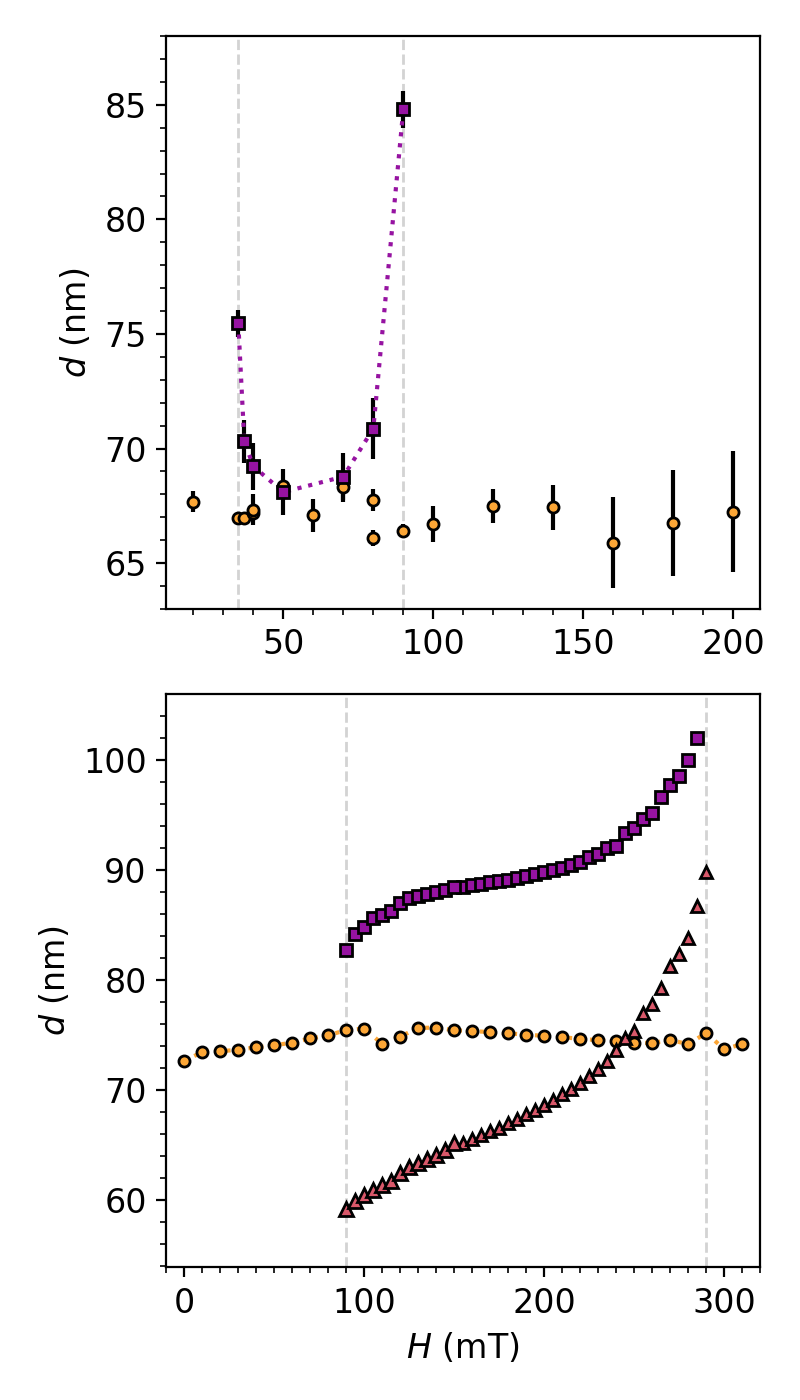

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidt

In [14]:
%matplotlib notebook
plt.figure(figsize=(4,7))

# Sets up nice colours for plot
start = 0.2
stop = 0.8
number_of_lines = 11
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.plasma(x) for x in cm_subsection ]

# Lists for plotting tick labels and values for all plots
ypos2 = [-1,0,1,1.4,2.4,3.4]
ylabels2 = [-1.0,0,1.0,-1.0,0,1.0]
ypos = [-0.5,0,0.5,0.7,1.2,1.7,1.9,2.4,2.9]
ylabels = [-0.5,0,0.5,-0.5,0,0.5,-0.5,0,0.5]
xpos2 = [0,12.5,25,37.5,50]
xlabels2 = [0,50,100,150,200]
xlabels1 = np.array([0,50,100,150])
xpos1 = [0,5,10,15]


##### Panel 1: Experimental Line Profile Wavelengths #####
ax1=plt.subplot2grid((2,1),(0,0), rowspan=1,colspan=1)

#Plots vertial grey dotted lines indicating extent of skyrmion tube phase.
plt.plot((35,35),(63,88),color='lightgrey',ls='--',lw=1,zorder=1)
plt.plot((90,90),(63,88),color='lightgrey',ls='--',lw=1,zorder=1)

#Plots error bars associated with experimental conical and skyrion tube distances.
plt.errorbar(fields,lams2, yerr = elist2,color='k',ls='',zorder=1)
plt.errorbar(fs,exp_cone_lam2, yerr = elist_cone_lam,color='k',ls='',zorder=2)
plt.errorbar(fs,exp_tube_lam2, yerr = elist_tube_lam,color='k',ls='',zorder=2)

#Plots experimental conical and skyrion tube distances.
plt.plot(fs,exp_cone_lam2,marker='o', markeredgecolor='k',color=colors[10],markersize=4,ls='')
plt.plot(fs,exp_tube_lam2,marker='s', markeredgecolor='k',color=colors[2],markersize=4,ls=':',zorder=2)
plt.plot(fields[:],lams2[:],color=colors[10],marker='o',markeredgecolor='k',markersize=4,ls='',zorder=2)

#Sets axis label and extent.
plt.ylabel('$d$ (nm)')
plt.ylim([63,88])

#Alters minor ticks on both axes.
mlx = MultipleLocator(10)
ax1.xaxis.set_minor_locator(mlx)
mly = MultipleLocator(1)
ax1.yaxis.set_minor_locator(mly)
################################


##### Panel 2: Simulated Lineprofile Wavelengths #####
ax2=plt.subplot2grid((2,1),(1,0), rowspan=1,colspan=1)
# Sets up field values and axis ticks to plot
flabels = [0,100,200,300]
fposs = [-30,-10,10,30]
new_fs = np.arange(0,len(sim_cone_lam2),1)*2-30

# Plots simulated conical lineprofile wavelengths
plt.plot(new_fs,sim_cone_lam2,color=colors[10],marker='o',markeredgecolor='k',markersize=4,ls=':')

# Plots field up skyrmion-skyrmion separation.
keys = sorted(sk_sk_rightm_tube_fieldup.keys())
plt.boxplot([sk_sk_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # boxplot locates the data in positions 1, 2, 3, ...
            # positions=[bz for bz in rightm_tube.keys()],
            # set the labels from the dictionary
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, showfliers=False, capprops=dict(linestyle=''), whiskerprops=dict(linestyle=''), medianprops = dict(linestyle=''), showbox=False, meanprops=dict(marker='s', markeredgecolor='k', markerfacecolor=colors[2],markersize=4, lw=0)
            )

# Plots field down skyrmion-skyrmion separation.
keysd = sorted(sk_sk_rightm_tube_fielddown.keys())
plt.boxplot([sk_sk_rightm_tube_fielddown[bz][:, 1] for bz in keysd],
            # position the data in negative indexes: -1, -2, ... so they dont overlap with the previous plot
            positions=np.arange(-len(keysd) + 1, 1),
            labels=[bz for bz in keysd],
            flierprops={'markersize': 1},
            showmeans=True, showfliers=False, capprops=dict(linestyle=''), whiskerprops=dict(linestyle=''), medianprops = dict(linestyle=''), showbox=False, meanprops=dict(marker='s', markeredgecolor='k', markerfacecolor=colors[2],markersize=4, lw=0)
            )

# Plots field up skyrmion-edge distance.
keys = sorted(sk_edge_rightm_tube_fieldup.keys())
plt.boxplot([sk_edge_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, showfliers=False, capprops=dict(linestyle=''), whiskerprops=dict(linestyle=''), medianprops = dict(linestyle=''), showbox=False, meanprops=dict(marker='^', markeredgecolor='k', markerfacecolor=colors[6],markersize=4, lw=0)
            )

# Plots field down skyrmion-edge distance.
keysd = sorted(sk_edge_rightm_tube_fielddown.keys())
plt.boxplot([sk_edge_rightm_tube_fielddown[bz][:, 1] for bz in keysd],
            positions=np.arange(-len(keysd) + 1, 1),
            labels=[bz for bz in keysd],
            flierprops={'markersize': 1},
            showmeans=True, showfliers=False, capprops=dict(linestyle=''), whiskerprops=dict(linestyle=''), medianprops = dict(linestyle=''), showbox=False, meanprops=dict(marker='^', markeredgecolor='k', markerfacecolor=colors[6],markersize=5, lw=0)
            )

#Sets axis labels, extent and tick values.
plt.ylabel('$d$ (nm)')
plt.xlabel('$H$ (mT)')
plt.xlim([-32,34])
plt.xticks(fposs,flabels)

#Alters minor ticks on both axes.
mlx = MultipleLocator(2)
ax2.xaxis.set_minor_locator(mlx)
mly = MultipleLocator(2)
ax2.yaxis.set_minor_locator(mly)

#Plots vertial grey dotted lines indicating extent of skyrmion tube phase.
plt.axvline(x=-12, zorder=0, color='lightgrey', alpha=1, lw=1,ls='--')
plt.axvline(x=28, zorder=0, color='lightgrey', alpha=1, lw=1,ls='--')
################################

plt.tight_layout()
plt.show();